In [37]:
import requests
import datetime
from datetime import date
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 

In [38]:
pd.set_option('display.max_columns', None)
df1=pd.read_csv('C:/Users/v-cheha/df1.csv')
df2=pd.read_csv('C:/Users/v-cheha/df2.csv')
df3=pd.read_csv('C:/Users/v-cheha/df3.csv')
df4=pd.read_csv('C:/Users/v-cheha/df4.csv')
df = df1.append(df2).append(df3).append(df4)
df.shape

(19674, 47)

In [39]:
cols = [0,1,5,9,10,42,43,44,45,46]
df = df.drop(df.columns[cols], axis =1).dropna(subset=['Value '])
df = df[(df['Preferred Positions '] != 'GK')].reset_index(drop=True)
df['Height '] = df['Height '].map(lambda x: x.split(' ')[0]).astype(int)
df['Weight '] = df['Weight '].map(lambda x: x.split(' ')[0]).astype(int)
df['BMI'] = df['Weight '] / (df['Height ']*df['Height ']) * 10000
df['BMI'] = df['BMI'].astype(int)
df['Value '] = df['Value '].str.replace(".", "").str.replace("£", "").astype(int)
df['Wage '] = df['Wage '].str.replace(".", "").str.replace("£", "").astype(int)
df['Deal'] = df['Value '] / df['Wage ']
df['Deal'] = df['Deal'].astype(int)
df = df.reset_index(drop=True)
print(df.shape)
df.tail(2)

(17286, 39)


,Height,Weight,Preferred Foot,Age,Preferred Positions,Player Work Rate,Value,Wage,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,Att. Position,Interceptions,Vision,Composure,Crossing,Short Pass,Long Pass,Acceleration,Stamina,Strength,Balance,Sprint Speed,Agility,Jumping,Heading,Shot Power,Finishing,Long Shots,Curve,FK Acc.,Penalties,Volleys,BMI,Deal
17284,184,77,Right,22,CM,Medium / Medium,45000,1500,45,40,43,46,45,56,49,37,45,38,39,38,56,53,55,34,60,54,52,54,61,42,40,29,25,38,32,40,30,22,30
17285,185,70,Right,21,ST,Medium / Medium,50000,1500,50,47,28,25,25,33,45,42,25,36,43,24,35,33,55,48,53,43,57,45,33,45,43,42,37,32,30,43,30,20,33


In [40]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer


### put everything together

In [ ]:
X, y = df.drop(['Value ','Wage ','Deal'], axis=1), df['Value ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

numerical_ix = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X_train.select_dtypes(include=['object', 'bool']).columns

t = [('cat', ce.OneHotEncoder(use_cat_names=True), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

model = RandomForestRegressor()
#model = GradientBoostingRegressor()
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

cv = KFold(n_splits=5, shuffle=True, random_state=0)

## very very important, the estimator needs to start with the step followed by double underscore __
## Parameters of pipelines can be set using __ separated parameter names
## https://stackoverflow.com/questions/61995448/invalid-parameter-n-neighbors-for-estimator-pipeline
#grid_param = {'m__n_estimators': [100, 300, 500]} 

grid_param = { 
            "m__n_estimators"      : [100, 300, 500],
            "m__max_features"      : ["auto", "sqrt", "log2"],
            "m__min_samples_split" : [2,4,8],
            "m__bootstrap": [True, False],
            }


gd_sr = GridSearchCV(pipeline,
                     param_grid=grid_param,
                     #scoring = make_scorer(mean_squared_error),
                     scoring='r2',
                     cv=cv,
                     n_jobs=3)

# This is for GradientBoostRegressor
# param_grid={'m__n_estimators':[100,200,500],
#             'm__max_depth': [4, 6, 8]} 

# gd_sr = GridSearchCV(pipeline,
#                      param_grid=param_grid,
#                      #scoring = make_scorer(mean_squared_error),
#                      scoring='r2',
#                      cv=5,#equivalent of setting it to KFold(n_splits=5)
#                      n_jobs=1)


gd_sr.fit(X_train, y_train)

print(gd_sr.best_params_)
print(gd_sr.best_score_)
print(gd_sr.best_estimator_)

In [42]:
y_pred = gd_sr.predict(X_test)
from sklearn.metrics import r2_score
test_score = r2_score(y_test, y_pred)
print(test_score)
# print(gd_sr.best_estimator_.named_steps['m'].feature_importances_)
## If you are using a pipeline, .i.e. your estimator is a pipeline object, you have to add the pipeline step name: optimized_GBM.best_estimator_.named_steps["step_name"].feature_importances_

0.9147159376022116
[2.25541845e-04 1.73536345e-04 2.31765194e-04 5.31118093e-05
 6.16411403e-05 1.74757028e-04 1.26442043e-04 4.31504700e-05
 9.33318992e-05 2.93953716e-04 1.46970034e-04 1.09670447e-04
 8.92610616e-05 2.51249319e-06 1.68601673e-04 7.91744854e-06
 2.68024279e-04 2.94553994e-04 3.52617139e-04 2.27545720e-04
 7.99821952e-05 8.91860494e-05 1.76139789e-05 3.95142474e-05
 6.45151992e-07 3.74223649e-02 1.16330202e-01 1.07490402e-02
 5.50810867e-03 4.70538950e-03 4.27979566e-02 3.32141389e-03
 6.70437637e-01 5.46899278e-03 5.80535319e-03 4.98534345e-03
 6.01449708e-03 3.05350701e-03 7.39891441e-03 5.30940894e-03
 3.55235927e-03 4.55941595e-03 5.07205224e-03 2.13895705e-03
 8.00297004e-03 3.59450122e-03 4.16591395e-03 5.70883186e-03
 4.71988122e-03 1.25913821e-02 2.68404801e-03 2.10237727e-03
 3.10502310e-03 2.52728241e-03 2.79502709e-03]


### get the feature importance

In [ ]:
pipeline.fit(X_train,y_train)
feature_name = pipeline.named_steps['prep'].transformers_[0][1].get_feature_names()

num_name = numerical_ix.tolist()
for i in range(len(num_name)):
    feature_name.append(num_name[i])
    i=i+1

feature_importance = gd_sr.best_estimator_.named_steps['m'].feature_importances_
output = pd.DataFrame(list(zip(feature_name,feature_importance)))
output.columns = ['feature_name','feature_importance']
output.sort_values(by='feature_importance', ascending=False)


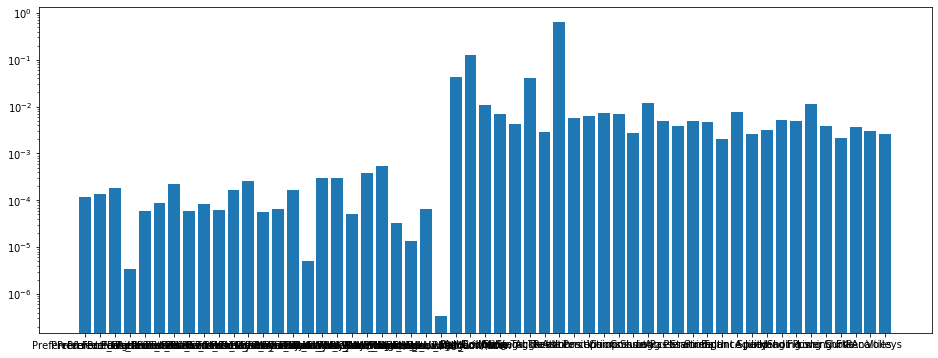

In [11]:

plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(feature_name, feature_importance, align='center')
#plt.bar(feature_name, feature_name, align='center')
#plt.xticks(range(len(feature_importance)), features, rotation='vertical')
#plt.title('Feature importance')
#plt.ylabel('Importance')
#plt.xlabel('Features')
plt.show()